In [1]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 127.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 116.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 110.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 98.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 130.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 73.9 MB/s eta 0:00:00
   ━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, RNN

2025-08-04 19:49:25.862943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-04 19:49:25.976033: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 19:49:25.981020: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda-12.8/lib64
2025-08-04

In [3]:
def create_dataset(signal, window_size=20):
    X, y = [], []
    for i in range(len(signal) - window_size):
        X.append(signal[i:i+window_size])
        y.append(signal[i+window_size])
    return np.array(X), np.array(y)

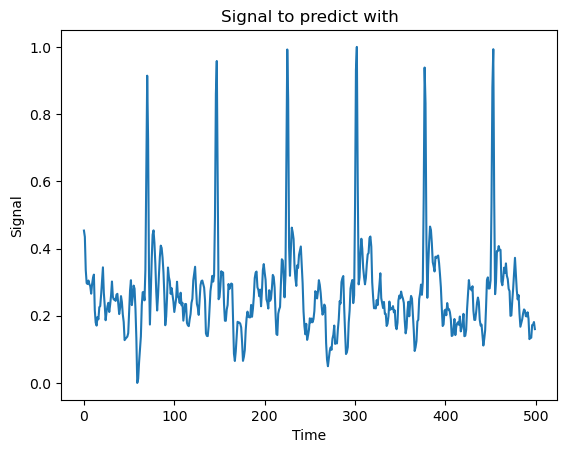

In [4]:
data = pd.read_csv('data/sparc_data_augmented.csv')
extracted_data = data.iloc[:, 1::].to_numpy()

clean_data = pd.read_csv('data/sparc_data.csv')
original_signal = clean_data.iloc[:, 1::].to_numpy()

scaler = MinMaxScaler(feature_range=(0,1))
og_scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(extracted_data)
scaled_original_signal = og_scaler.fit_transform(original_signal)

plt.plot(scaled_original_signal)
plt.title('Signal to predict with')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.show()

In [5]:
X_train_all, y_train_all = [], []
window_size = 20

for i in range(scaled_data.shape[1]):  # a list of 10 signals
    X_aug, y_aug = create_dataset(scaled_data[:, i], window_size)
    X_train_all.append(X_aug)
    y_train_all.append(y_aug)

# Combine all augmented data into single arrays
X_train = np.concatenate(X_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)

# Reshape if univariate (LSTM expects shape (samples, timesteps, features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, activation='relu', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')

2025-08-04 19:49:27.739049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-04 19:49:27.742289: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda-12.8/lib64
2025-08-04 19:49:27.742408: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda-12.8/lib64
2025-08-04 19:49:27.742480: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64

In [7]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=False)
model.save("data/pretrained_LSTM.h5")

Epoch 1/35
600/600 [==============================] - 26s 40ms/step - loss: 0.0219 - val_loss: 0.0175
Epoch 2/35
600/600 [==============================] - 23s 38ms/step - loss: 0.0173 - val_loss: 0.0165
Epoch 3/35
600/600 [==============================] - 23s 38ms/step - loss: 0.0166 - val_loss: 0.0158
Epoch 4/35
600/600 [==============================] - 23s 39ms/step - loss: 0.0158 - val_loss: 0.0154
Epoch 5/35
600/600 [==============================] - 23s 39ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 6/35
600/600 [==============================] - 23s 39ms/step - loss: 0.0145 - val_loss: 0.0136
Epoch 7/35
600/600 [==============================] - 23s 39ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 8/35
600/600 [==============================] - 23s 39ms/step - loss: 0.0130 - val_loss: 0.0117
Epoch 9/35
600/600 [==============================] - 24s 39ms/step - loss: 0.0123 - val_loss: 0.0111
Epoch 10/35
600/600 [==============================] - 27s 45ms/step - loss: 0.011

In [11]:
seed_sequence = np.copy(scaled_original_signal[-window_size:]) 

# List to store predictions
predictions = []
nb_predictions = 100

# Make n predictions
for i in range(nb_predictions):
    # Reshape to model input shape: (1, window_size, 1)
    input_seq = np.reshape(seed_sequence[i:window_size+i], (1, window_size, 1))
    
    # Predict next value (shape will be (1, 1))
    next_val = model.predict(input_seq, verbose=0)[0, 0]
    
    # Append prediction to results
    predictions.append(next_val)
    seed_sequence = np.append(seed_sequence, next_val)
    
#predictions = og_scaler.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()

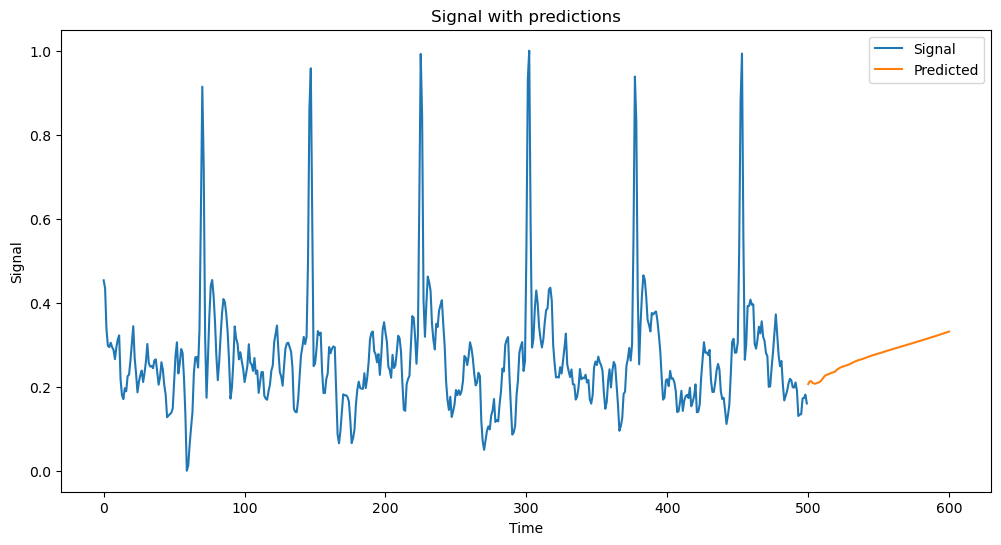

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(scaled_original_signal, label='Signal')
plt.plot(np.linspace(len(original_signal), len(original_signal) + nb_predictions, nb_predictions),predictions, label='Predicted')
plt.title('Signal with predictions')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()
plt.show()